## State Schema with DataClasses

When defining a LangGraph `StateGraph`, we use a **state schema** to represent the structure and types of data that flows through the graph.

**Key Points:**

- All nodes communicate using the same state schema
- LangGraph offers flexibility in how you define your schema
- You can use `TypedDict` from Python's `typing` module to specify keys and their value types

**Important Note:**

These are **type hints**, not runtime enforcement:
- Static type checkers (like mypy) and IDEs can catch type-related errors before execution
- Types are **not enforced at runtime** - they serve as documentation and development aids

### Imports
Import the required libraries for LangGraph, LangChain, and type annotations.

In [2]:
import os
from typing import TypedDict, Literal, Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

from dotenv import load_dotenv

load_dotenv()

OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")

### Define State Schema
Create a `TypedDict` class that defines the structure of the state. This schema will be used by all nodes in the graph.

In [8]:
# Example: Defining State Schema using TypedDict

from typing import TypedDict

class State(TypedDict):
    """
    State schema for our LangGraph workflow.
    This defines the structure of data that flows through all nodes.
    """
    name: str           # User's name
    messages: list      # List of conversation messages
    count: int          # Counter for tracking iterations

### Define Node Functions
Create node functions that receive the state as input and return updates to the state. Each node performs a specific task.

In [4]:
# Add nodes
def greet_user(state: State) -> dict:
    """Node that greets the user by name."""
    print(f"Hello, {state['name']}!")
    return {"count": state.get("count", 0) + 1}

def add_message(state: State) -> dict:
    """Node that adds a message to the conversation."""
    new_message = f"Message #{state['count']}: Welcome to LangGraph!"
    return {"messages": state.get("messages", []) + [new_message]}

#### code explanation:

`return {"messages": state.get("messages", []) + [new_message]}`

- state.get("messages", []) - Gets the existing messages list, or returns an empty list [] if it doesn't exist
- [new_message] - Appends the new message to the list
- Returns a dictionary that updates the messages key in the state

### Build the Graph
Initialize the `StateGraph` with the state schema, add nodes and edges, then compile the graph.

In [5]:
# Build the graph
graph = StateGraph(State)
graph.add_node("greet", greet_user)
graph.add_node("add_msg", add_message)
graph.add_edge(START, "greet")
graph.add_edge("greet", "add_msg")
graph.add_edge("add_msg", END)

# Compile and test
app = graph.compile()

### Invoke the Graph
Run the compiled graph with an initial state and print the final result.

In [6]:
# Invoke with initial state
result = app.invoke({"name": "Alice", "messages": [], "count": 0})
print("\nFinal State:", result)

Hello, Alice!

Final State: {'name': 'Alice', 'messages': ['Message #1: Welcome to LangGraph!'], 'count': 1}


### Display the graph

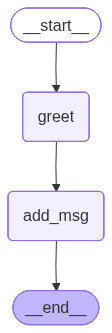

In [7]:
## Display
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Dataclasses

Python's `dataclasses` provide an alternative way to define structured data for LangGraph state schemas.

**Benefits of Dataclasses:**

- Concise syntax for creating classes that store data
- Automatic generation of `__init__`, `__repr__`, and `__eq__` methods
- Type hints are built into the class definition
- Can be used with LangGraph's `dataclass` state schema support

### Dataclasses vs Pydantic

| Feature | Dataclasses | Pydantic |
|---------|-------------|----------|
| **Runtime Validation** | ❌ No validation | ✅ Automatic validation at runtime |
| **Type Enforcement** | Type hints only (not enforced) | Types are enforced when data is created |
| **Serialization** | Manual or requires additional libraries | Built-in JSON/dict serialization |
| **Default Values** | Supported | Supported with validators |
| **Performance** | Faster (lightweight) | Slightly slower (due to validation) |
| **Dependencies** | Built-in Python (3.7+) | Requires `pydantic` package |

**When to use:**
- **Dataclasses**: Simple data containers, internal use, performance-critical code
- **Pydantic**: API inputs, configuration files, data from external sources, when validation is needed

In [9]:
from dataclasses import dataclass

@dataclass
class State:
    name: str
    count: int = 0

# No validation - this works even with wrong types!
state = State(name=123, count="hello")  # No error

In [10]:
from pydantic import BaseModel

class State(BaseModel):
    name: str
    count: int = 0

# Validation happens automatically
state = State(name="Alice", count=5)     # ✅ Works
state = State(name=123, count="hello")   # ❌ ValidationError!

ValidationError: 2 validation errors for State
name
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
count
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='hello', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/int_parsing